# Импортируем библиотеки

In [1]:
import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#mean_absolute_percentage_error нет в sklearn v0.22, поэтому напишем сами:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

from sklearn.metrics import mean_squared_error , max_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor

import xgboost as xgb
import optuna
import lightgbm as lgbm
 
np.random.seed(42)

# Предобработка данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
df.iloc[2]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          2005 Westridge Rd
baths                                                     2 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '1961', 'fac...
fireplace                                                     yes
city                                                  Los Angeles
schools         [{'rating': ['8/10', '4/10', '8/10'], 'data': ...
sqft                                                   3,000 sqft
zipcode                                                     90049
beds                                                       3 Beds
state                                                          CA
stories                                                       1.0
mls-id                                                        NaN
PrivatePoo

In [5]:
df.shape

(377185, 18)

Количество пропущенных значенний:

In [6]:
df.isna().sum() / (df.shape[0])*100 #процент пропусков

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.661956
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.957846
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

Удаляем строки без целевой переменной:

In [7]:
df = df.loc[df['target'].isna() == False]

In [8]:
df.shape

(374704, 18)

Очищаем целевую переменную:

In [9]:
def target_format(target):
    target = re.sub('[^0-9]', '', target) #оставляем только цифры
    target = int(target)
    return target

In [10]:
df['target'] = df['target'].apply(target_format)
df['target'].describe()

count    3.747040e+05
mean     6.447575e+05
std      1.841431e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.821000e+05
max      1.950000e+08
Name: target, dtype: float64

Очищаем признаки:

In [11]:
# Преобразовываем в действительные числа
def features_float_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('1 1/2', '1.5', str(feature)) # заменяем 1 1/2 на 1.5 (признак stories)
    feature = re.sub('[^0-9,\.]', '', feature) # оставляем только цифры
    feature = re.sub(',', '.', feature) # заменяем ',' на '.'
    
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем площадь
def sqft_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('[^0-9\.]', '', feature) # оставляем только цифры
   
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем статус
def status_format(status):
    status = status.lower()
    # если дом ещё не сделан,оставляем только 'coming soon', дату удаляем
    if status.startswith('coming soon'): 
        status = 'coming soon'
        
    status = re.sub('[^a-z]', ' ', status) # оставляем только буквы
    status = re.sub(r'\b\w{,2}\b', '', status) # удаляем сочетание из 1 и 2 букв
    status = re.sub(r'\s+', '', status) # заменяем 1 или более пробелов на ''
    if status == 'active' or status == 'for sale': # бóльшая часть домов - for sale или active
        status = 1
    else:
        status = 0
    return status
#Преобразовываем фичу камина
def fireplace_format(fireplace):
    if fireplace == 0:
        return fireplace
    fireplace = fireplace.lower()
    
    if fireplace.count('no')>0:
        fireplace = 0
    else:
        fireplace = 1
    return fireplace

In [12]:
dummy_features = ['status','state']  
drop_features = ['street', 'mls-id', 'MlsId', 'schools', 'homeFacts', 'city', 'zipcode'] 

#### Status

In [13]:
df.status.value_counts()

for sale                  156100
Active                    105206
For sale                   43465
foreclosure                 5677
New construction            5459
                           ...  
Contract                       1
Pending Take Backups           1
Under Contract W/ Bckp         1
Coming soon: Oct 29.           1
Coming soon: Nov 11.           1
Name: status, Length: 156, dtype: int64

Приблизительно 80% домов - ```Active``` или ```for sale```, поэтому вместо них ставим ```1```, иначе ```0```
(заполняем пропуски на пустые строки, и применяем ```status_format```):

In [14]:
df['status'] = df['status'].fillna('')
df['status'] = df['status'].apply(status_format)

#### Property Type

In [15]:
df.propertyType.value_counts()

single-family home                              91376
Single Family                                   61888
Single Family Home                              31725
condo                                           25878
lot/land                                        20532
                                                ...  
Single Detached, Southwestern                       1
Manufactured Home - Double Wide                     1
1 Story, Contemporary, Colonial, Traditional        1
Spanish, Split Level                                1
1 Story, Split Level, Mediterranean                 1
Name: propertyType, Length: 1279, dtype: int64

Приблизительно 50% домов - ```single family```, поэтому оставляем только этот признак:

In [16]:
def propertyType_format(propertyType):
    propertyType = propertyType.lower()
    propertyType = re.sub('[^a-z]', ' ', propertyType)# оставляем только буквы
    
    # если начинается на 'single family' - ставим 1, иначе 0
    if propertyType.startswith('single family'): 
        propertyType = 1 
    else:
        propertyType = 0
    return propertyType

In [17]:
df['propertyType'] = df['propertyType'].fillna('')
df['propertyType'] = df['propertyType'].apply(propertyType_format)

#### Private pool
Вместо пропусков ставим ```no```, заполняем вместо ```yes``` - 1, вместо ```no``` - 0

In [18]:
df['private pool'] = df['private pool'].fillna('no')
df['private pool'] = df['private pool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['PrivatePool'].fillna('no')
df['PrivatePool'] = df['PrivatePool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['private pool'] | df['PrivatePool']
df.drop(['private pool'], axis = 1, inplace = True)

#### Baths, sqft, beds, stories, fireplace
Заполняем пропуски нулями (кроме этажей - их заменяем на ```1```).
К ```Baths, beds, stories``` применяем ```features_float_format```, к ```sqft - sqft_format```, а к ```fireplace``` - ```fireplace_format```:

In [19]:
df['baths'] = df['baths'].fillna(0)
df['baths'] = df['baths'].apply(features_float_format)

df['sqft'] = df['sqft'].fillna(0)
df['sqft'] = df['sqft'].apply(sqft_format)

df['beds'] = df['beds'].fillna(0)
df['beds'] = df['beds'].apply(features_float_format)

df['stories'] = df['stories'].fillna(1)
df['stories'] = df['stories'].apply(features_float_format)

df['fireplace'] = df['fireplace'].fillna(0)
df['fireplace'] = df['fireplace'].apply(fireplace_format)

#### Year Built

In [20]:
df['homeFacts'] = df['homeFacts'].apply(eval) # конвертируем строку в словарь, используя eval

Нужное нам значение хранится в первом словаре, который хранится в списке, который, в свою очередь, хранится в словаре с ключом ```atAGlanceFacts```:

In [21]:
M = df['homeFacts'][0]
print(M,'\n')
print(M['atAGlanceFacts'],'\n')
print(M['atAGlanceFacts'][0],'\n')
print(M['atAGlanceFacts'][0]['factValue'])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]} 

[{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}] 

{'factValue': '2019', 'factLabel': 'Year built'} 

2019


In [22]:
def yearBuilt_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём первый елемент списка
    yearBuilt = homeFacts[0]
    # если словарь не пуст, то берем значение
    if yearBuilt.get('factLabel') == 'Year built':
        yearBuilt = yearBuilt.get('factValue')
    # берём первый второй списка
    yearRemodeled = homeFacts[1]
    # если словарь не пуст, то берем значение
    if yearRemodeled.get('factLabel') == 'Remodeled year':
        yearRemodeled = yearRemodeled.get('factValue')
    
    # если yearRemodeled - число, выводим его, иначе - yearBuilt
    try:
        yearRemodeled = int(yearRemodeled)
        return yearRemodeled
    except:
        yearRemodeled = 0
    # если homeFacts - число, то выводим его, иначе 0
    try:
        yearBuilt = int(yearBuilt)
    except:
        yearBuilt = 0
    return yearBuilt

In [23]:
df['yearBuilt'] = df['homeFacts'].apply(yearBuilt_format)

#### Heating

In [24]:
def heating_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём третий елемент списка
    homeFacts = homeFacts[2]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Heating':
        homeFacts = homeFacts.get('factValue')
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что в доме нет отопления
        return 0
    else:
        return 1

In [25]:
df['heating'] = df['homeFacts'].apply(heating_format)

#### Parking

In [26]:
def parking_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём пятый елемент списка
    homeFacts = homeFacts[4]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Parking':
        homeFacts = homeFacts.get('factValue')
        homeFacts = str(homeFacts).lower()
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что участке нет парковки
        homeFacts = 0
    else:
        homeFacts = re.sub('[^0-9]', '', homeFacts) # оставляем только цифры
        try:
            homeFacts = int(homeFacts)
            
        # Если homeFacts - строка ('Attached Garage'...), считаем, что в доме 1 парковка
        except:
            homeFacts = 1
    return homeFacts

In [27]:
df['parking'] = df['homeFacts'].apply(parking_format)

#### Lot size

In [28]:
def lotsize_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём шестой елемент списка
    homeFacts = homeFacts[5]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'lotsize':
        homeFacts = str(homeFacts.get('factValue'))
        
    if homeFacts == 0:
        return homeFacts
    homeFacts = homeFacts.replace('Sq. Ft.','')
    homeFacts = re.sub('[^0-9\.]', '', homeFacts) # оставляем только цифры
   
    try:
        homeFacts = float(homeFacts)
    #если homeFacts - пустая строка, возвращаем 0
    except:
        homeFacts = 0
    if homeFacts < 10: # если homeFacts подано в акрах
        homeFacts *= 43560
    return homeFacts

Если lotsize равно 0, то записываем в lotsize значенние в sqft:

In [29]:
df['lotsize'] = df.apply(lambda x: x['sqft'] if lotsize_format(x['homeFacts']) == 0 
                         else lotsize_format(x['homeFacts']), 
                         axis = 1)

#### Schools rating

In [30]:
df['schools'] = df['schools'].apply(eval) # конвертируем строку в словарь, используя eval

Список с рейтингами школ хранится в словаре, который хранится в списке:

In [31]:
M = df['schools'][0]
print(M,'\n')
print(M[0],'\n')
print(M[0]['rating'])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}] 

{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']} 

['4', '4', '

In [32]:
def rating_format(schools):
    # если schools - непустой словарь, берём значение 'rating', иначе 0
    schools = schools[0]
    schools = schools.get('rating', 0)
    if schools == 0: 
        return 0
    
    rating = []
    for x in schools:
        x = re.sub('/10','',x) # если рейтинг записан в формате 'x/10', заменяем на 'x'
        rating.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое рейтингов
    return np.mean(rating)

Применяем ```rating_format```, если результат - ```nan```, заменяем на ```0```:

In [33]:
df['rating'] = df['schools'].apply(rating_format)
df['rating'] = df['rating'].fillna(0)

C:\Users\andru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.



#### Distance
По аналогии с ```rating```, выбираем значение из списка словарей и ищем среднее арифметическое расстояний

In [34]:
def distance_format(schools):
    # если schools - непустой словарь, берём значение 'data', иначе 0
    schools = schools[0]
    schools = schools.get('data', 0)
    if schools == 0: 
        return 0
    # если schools - непустой словарь, берём значение 'distance', иначе 0
    schools = schools.get('Distance', 0)
    if schools == 0: 
        return 0
    
    distance=[]
    for x in schools:
        distance.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое расстояний
    return np.mean(distance)

Применяем ```distance_format``` и заполняем пропуски нулями:

In [35]:
df['distance'] = df['schools'].apply(distance_format)
df['distance'] = df['distance'].fillna(0)

Удаляем ненужные фичи:

In [36]:
df.drop(drop_features, axis = 1, inplace = True)

#### State 
Штаты - dummy-feature, поэтому применяем к ```df['state']``` функцию ```pd.get_dummies```, и конкатенируем результат к датасету:

In [37]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis = 1)
df.drop('state', axis = 1, inplace = True)

##### Итог:
Мы предобработали и очистили данные, и получили 54 признака, из которых 10 - числовых, а остальные - dummy-features (принимают лишь значения 1 и 0).

# Статистический анализ

In [38]:
df.head()

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
0,1,1,3.5,1,2900.0,4.0,1.0,0,418000,2019,...,0,0,0,0,0,0,0,0,0,0
1,0,1,3.0,0,1947.0,3.0,2.0,0,310000,2019,...,0,0,0,0,0,0,0,0,1,0
2,0,1,2.0,1,3000.0,3.0,1.0,1,2895000,1967,...,0,0,0,0,0,0,0,0,0,0
3,0,1,8.0,1,6457.0,5.0,3.0,0,2395000,2006,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0.0,0,0.0,0.0,1.0,0,5000,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df.describe(include = 'all')

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
count,374704.000000,374704.000000,3.747040e+05,374704.000000,3.747040e+05,374704.000000,374704.000000,374704.000000,3.747040e+05,3.747040e+05,...,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000
mean,0.281953,0.493694,3.718902e+02,0.267360,5.921395e+03,2.417060,1.500874,0.118152,6.447575e+05,2.990631e+06,...,0.000003,0.014705,0.000075,0.048654,0.222464,0.003525,0.002135,0.002306,0.036666,0.001206
std,0.449951,0.499961,1.928389e+05,0.442583,1.499304e+06,3.936648,3.338053,0.322788,1.841431e+06,1.293752e+09,...,0.001634,0.120369,0.008644,0.215145,0.415901,0.059271,0.046157,0.047964,0.187941,0.034711
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,1.035000e+03,0.000000,1.000000,0.000000,1.869900e+05,1.936000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000e+00,0.000000,1.656000e+03,3.000000,1.000000,0.000000,3.200000e+05,1.981000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000e+00,1.000000,2.458000e+03,4.000000,2.000000,0.000000,5.821000e+05,2.006000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.161161e+08,1.000000,7.959794e+08,871.000000,1120.000000,1.000000,1.950000e+08,5.599906e+11,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Построим матрицу корреляций:

In [40]:
corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "5pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '8pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())

Избыточной кореляции между признаками нету, значит никаких признаков удалять ненужно. 
Построим гистограмы с различными признаками:

Построим гистограмму логарифма целевой переменной:

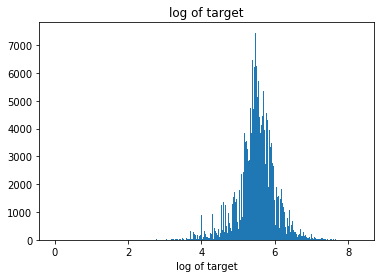

In [41]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Отсюда видно, что существует пик в точке 5.5, а распределение - похоже на нормальное.

Удалим объекты, где стоимость домов меньше ```1000$``` или больше ```100 000 000$```:

In [42]:
df = df.loc[(df['target']> 10**3.5) & (df['target'] < 10**7.5)]

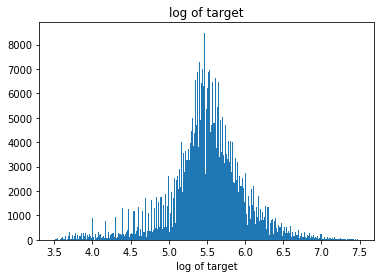

In [43]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Построим гистограмму логарифма площади, если площадь не равна ```0```:

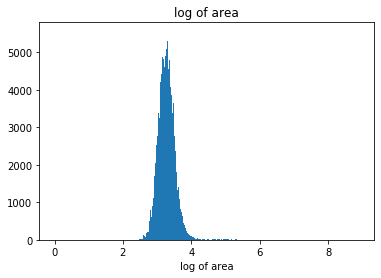

In [44]:
_ = plt.hist(np.log10(df.loc[(df['sqft']>0)]['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Удалим объекты, где площадь домов меньше ```300``` или больше ```10 000``` кв. фт:

In [45]:
df = df.loc[(df['sqft']> 300) & (df['sqft'] < 10**4)]

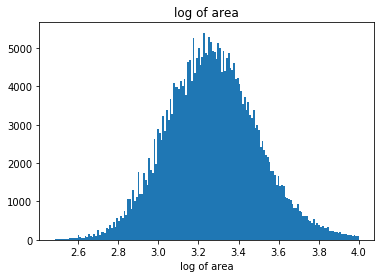

In [46]:
_ = plt.hist(np.log10(df['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Видно пик около 3.25. Значит, большинство значенний площади находятся на промежутке от около ```1000``` до ```10000```.

Построим гистограмму распределений кроватей:

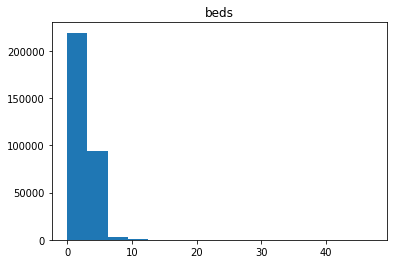

In [47]:
_ = plt.hist(df['beds'],bins = 15)
plt.title('beds')
plt.show()

Удалим объекты, где количество кроватей больше ```20```:

In [48]:
df = df.loc[df['beds'] <= 20]

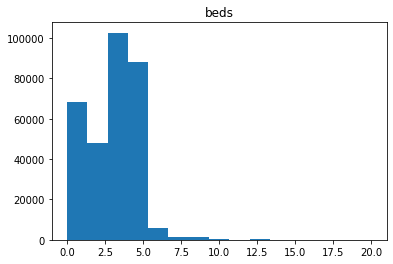

In [49]:
_ = plt.hist(df['beds'],bins = 15)
plt.title('beds')
plt.show()

Построим гистограмму распределений логарифма lot siz'а, убрав объекты, где lotsize равно ```0```:

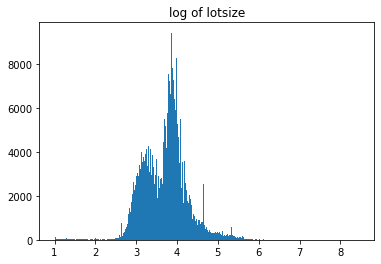

In [50]:
_ = plt.hist(np.log10(df[df['lotsize']>0]['lotsize']),bins = 'auto')
plt.title('log of lotsize')
plt.show()

Заменим значенния этажей больше ```100``` на ```2```:

In [51]:
df['stories'] = df['stories'].where(df['stories']<100,2)

Построим гистограмму распределений рейтинга школ:

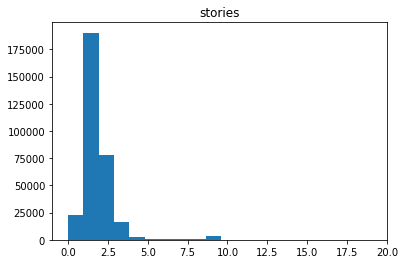

In [52]:
_ = plt.hist(df['stories'],bins = 100)
plt.title('stories')
plt.xlim(-1,20)
plt.show()

Построим гистограмму распределений рейтинга школ:

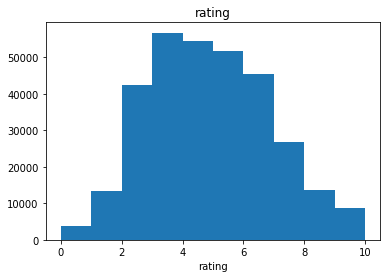

In [53]:
_ = plt.hist(df['rating'],bins = 10)
plt.title('rating')
plt.xlabel('rating')
plt.show()

Построим гистограмму логарифма расстояний:

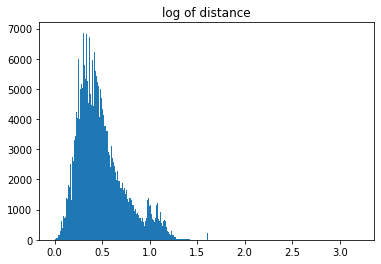

In [54]:
_ = plt.hist(np.log10(df['distance']+1),bins = 'auto')
plt.title('log of distance')
plt.show()

Заменим значенния ванных больше ```40``` на ```2```:

In [55]:
df['baths'] = df['baths'].where(df['baths']<40,2)

Построим гистограмму распределений ванных, убрав объекты, где количество ванных больше 20 или равно 0:

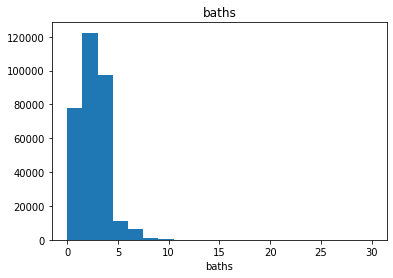

In [56]:
_ = plt.hist(df['baths'],bins = 20)
plt.title('baths')
plt.xlabel('baths')
plt.show()

Заменим значенния ```yearBuilt``` больше ```2021``` и меньше ```1900``` на ```2019```:

In [57]:
df['yearBuilt'] = df['yearBuilt'].where((df['yearBuilt'] < 2021) & (df['yearBuilt'] > 1900),2019)

Построим гистограмму распределений года постройки:

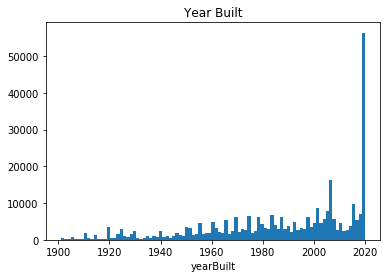

In [58]:
_ = plt.hist(df['yearBuilt'],bins = 'auto')
plt.title('Year Built')
plt.xlabel('yearBuilt')
plt.show()

In [59]:
df['parking'] = df['parking'].where(df['parking']<20,1)

Построим гистограмму распределений количества парковок:

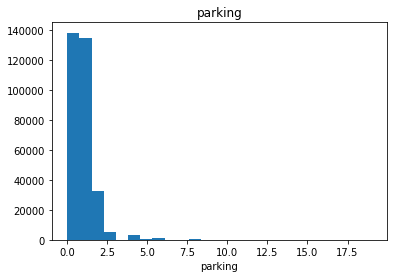

In [60]:
_ = plt.hist(df['parking'],bins = 25)
plt.title('parking')
plt.xlabel('parking')
plt.show()

###### Boxplots

Логарифм площади:

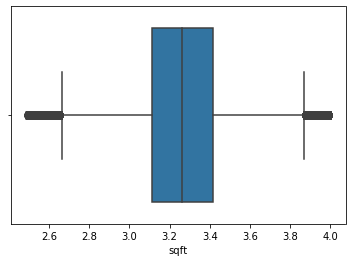

In [61]:
sns.boxplot(x=np.log10(df['sqft']+1))

Логарифм цены:

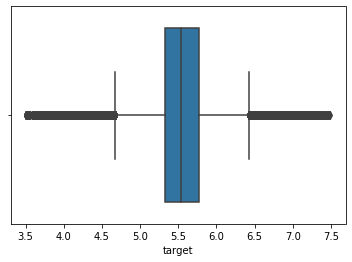

In [62]:
sns.boxplot(x=np.log10(df['target']))

Кровати:

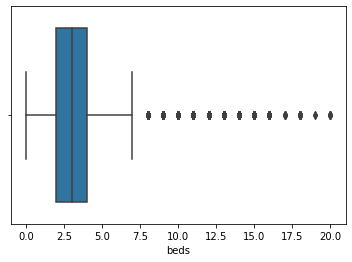

In [63]:
sns.boxplot(x=df['beds'])

Логарифм площади участка:

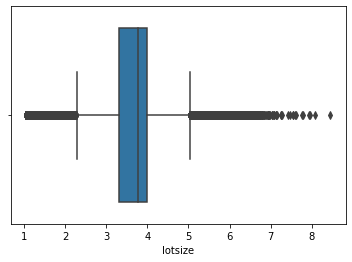

In [64]:
sns.boxplot(x=np.log10(df['lotsize']+1))

Рейтинг школ:

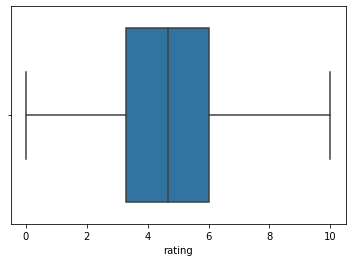

In [65]:
sns.boxplot(x=df['rating'])

Логарифм расстояний до школ:

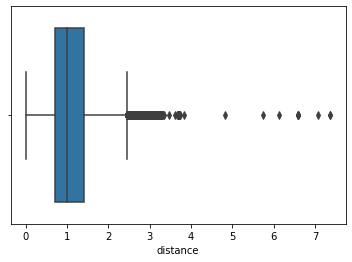

In [66]:
sns.boxplot(x=np.log(df['distance']+1))

Год постройки:

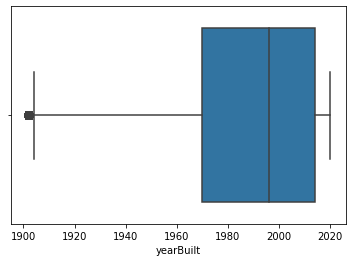

In [67]:
sns.boxplot(x=df['yearBuilt'])

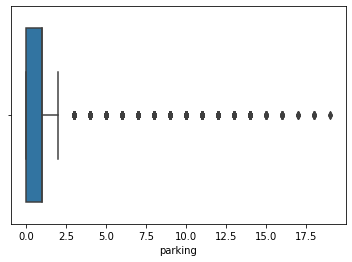

In [68]:
sns.boxplot(x=df['parking'])

###### Точечные диаграммы целевой переменной и признаков

Построим точечную диаграмму целевой переменной и рейтинга школ:

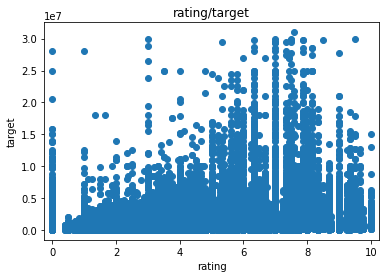

In [69]:
_ = plt.scatter(df['rating'],df['target'])

plt.xlim(-0.25,10.25)

plt.title('rating/target')
plt.xlabel('rating')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и логарифма расстояний до школ:

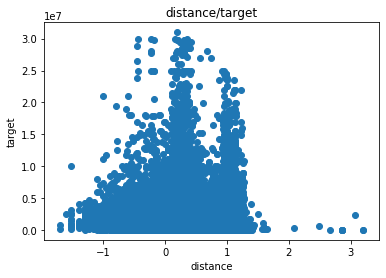

In [70]:
_ = plt.scatter(np.log10(df.loc[df['distance']>0]['distance']),df.loc[df['distance']>0]['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов

plt.title('distance/target')
plt.xlabel('distance')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма количества этажей:

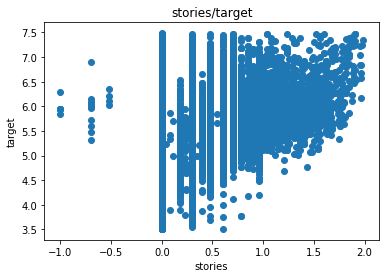

In [71]:
M = df.loc[(df['stories']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['stories']),
                np.log10(M['target']))

plt.title('stories/target')
plt.xlabel('stories')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и количества кроватей:

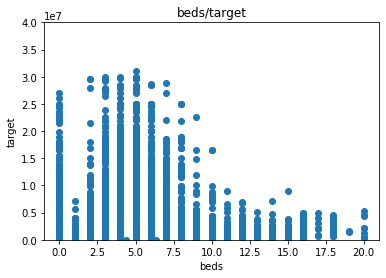

In [72]:
_ = plt.scatter(df['beds'],df['target'])
# Ограничим график по осям
plt.xlim(-1,21)
plt.ylim(-10,1e7*4)

plt.title('beds/target')
plt.xlabel('beds')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и года постройки:

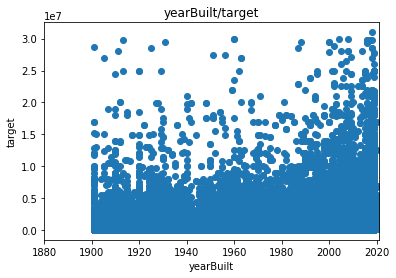

In [73]:
_ = plt.scatter(df['yearBuilt'],df['target'])

plt.title('yearBuilt/target')
plt.xlabel('yearBuilt')
plt.ylabel('target')

plt.xlim(1880,2021)

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма площади:

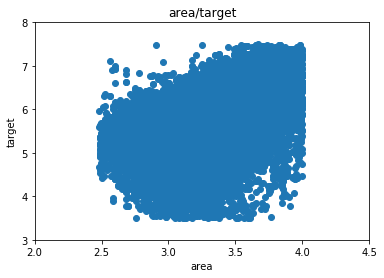

In [74]:
M = df.loc[(df['sqft']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['sqft']),
                np.log10(M['target']))
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(2,4.5)
plt.ylim(3,8)

plt.title('area/target')
plt.xlabel('area')
plt.ylabel('target')

plt.show()

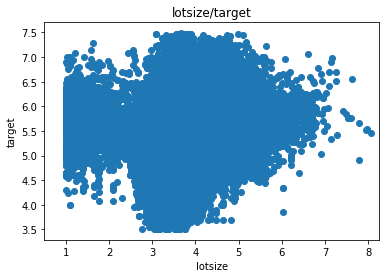

In [75]:
M = df.loc[(df['lotsize']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['lotsize']),
                np.log10(M['target']))
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(0.5,8.25)

plt.title('lotsize/target')
plt.xlabel('lotsize')
plt.ylabel('target')

plt.show()

Поскольку распределения логарифма целевой переменной, логарифма lotsiz'а, логарифма площади и логарифма расстояний до школ - похожы на нормальные, то можна к этим признакам применить логарифм:

In [76]:
df = df.loc[(df['sqft']>0) & (df['distance']>0)] # берём только значения больше 0 (log(0)=-inf)
df['sqft'] = df['sqft'].apply(lambda x: np.log10(x))
df['distance'] = df['distance'].apply(lambda x: np.log10(x))
df['lotsize'] = df['lotsize'].apply(lambda x: np.log10(x+1))

Для ```target``` воспользуемся ```TransformedTargetRegressor```

Разобьем датафрейм на 2: в одном отдельные домы (```'single home'```), в других - остальные(квартиры, кондоминиумы):

In [77]:
#df = df.loc[df['propertyType']==0]
#df = df.drop('propertyType',axis=1)
df_single = df.loc[df['propertyType'] == 1]  
df_condo = df.loc[df['propertyType'] == 0]
df_single = df_single.drop('propertyType',axis = 1)
df_condo = df_condo.drop('propertyType',axis = 1) 

##### Итог: проведен анализ данных, нормализировано некоторые признаки 

# Построение моделей

Разобьем данные на обучающаю и тестовую выборки:

In [78]:
X_single, y_single = df_single.drop('target', axis = 1), df_single['target']
X_condo, y_condo = df_condo.drop('target', axis = 1), df_condo['target']

In [79]:
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y_single, 
                                                                                test_size = 0.2, random_state = 42)

X_train_condo, X_test_condo, y_train_condo, y_test_condo = train_test_split(X_condo, y_condo,
                                                                            test_size = 0.2, random_state = 42)

In [80]:
X_train_single.shape, y_train_single.shape, X_test_single.shape, y_test_single.shape

((143334, 52), (143334,), (35834, 52), (35834,))

In [81]:
X_train_condo.shape, y_train_condo.shape, X_test_condo.shape, y_test_condo.shape

((108242, 52), (108242,), (27061, 52), (27061,))

Списки с моделями для финального стекинга:

In [82]:
estimators_single = []
estimators_condo = []

Сделаем функцию для оценки точности предсказаний:

In [83]:
def evaluate(clf, X_train, y_train, X_test, y_test):
    #делаем предсказание
    train_predict = clf.predict(X_train)
    test_predict = clf.predict(X_test)
    #mse
    print('train mse :', mean_squared_error(y_train, train_predict) )
    print('test mse  :', mean_squared_error(y_test, test_predict) ,'\n')
    #max error
    print('train max error :', max_error(y_train, train_predict) )
    print('test max error  :', max_error(y_test, test_predict) ,'\n')
    #RMSE
    print('train rmse :', np.sqrt(mean_squared_error(y_train, train_predict) ))
    print('test rmse  :',np.sqrt(mean_squared_error(y_test, test_predict) ),'\n')
    #Coefficient of determination
    print('train R^2', clf.score(X_train,y_train)) 
    print('test R^2', clf.score(X_test,y_test),'\n')
    #MAE
    print('train mean absolute error :', mean_absolute_error(y_train, train_predict) )
    print('test mean absolute error  :', mean_absolute_error(y_test, test_predict) ,'\n')
    #MAPE
    print('train mean absolute percentage error :', mean_absolute_percentage_error(y_train, train_predict) )
    print('test mean absolute percentage error  :', mean_absolute_percentage_error(y_test, test_predict) ,'\n')    

### Линейная регрессия

In [84]:
lr = LinearRegression()
# Применяем логарифм к целевой переменной
regr = TransformedTargetRegressor(regressor = lr, func=np.log, inverse_func=np.exp) 
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [85]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single) 

train mse : 445505876014.1527
test mse  : 784044714016.8103 

train max error : 33967413.99850291
test max error  : 107929806.2387214 

train rmse : 667462.265610688
test rmse  : 885462.9941543634 

train R^2 0.47717403586188856
test R^2 0.03383696744114373 

train mean absolute error : 217124.49842121074
test mean absolute error  : 219010.42939192377 

train mean absolute percentage error : 0.478914992751534
test mean absolute percentage error  : 0.49385301683306804 



In [86]:
lr = LinearRegression()
# Применяем логарифм к целевой переменной
regr = TransformedTargetRegressor(regressor = lr, func=np.log, inverse_func=np.exp) 

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [87]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 1045215559042.3949
test mse  : 1120621390662.996 

train max error : 38517032.87646974
test max error  : 27536619.293164283 

train rmse : 1022357.8429504979
test rmse  : 1058594.0632097821 

train R^2 0.3595515699214412
test R^2 0.364232129020574 

train mean absolute error : 323871.41137832927
test mean absolute error  : 327459.4092640501 

train mean absolute percentage error : 0.7375089919673644
test mean absolute percentage error  : 0.7123530615629912 



Попробуем различные деревья решений:

### Деревья решений

С помощью ```optune``` переберём различные варианты ```max_depth```:

In [88]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 4, 12)
    
    tree_single = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = tree_single, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 8)

[I 2020-10-21 18:35:18,123] A new study created in memory with name: no-name-7af21f18-f464-43c6-a19d-6dfd569240ef
[I 2020-10-21 18:35:19,145] Trial 0 finished with value: 428911396314.7777 and parameters: {'tree_max_depth': 8}. Best is trial 0 with value: 428911396314.7777.
[I 2020-10-21 18:35:19,713] Trial 1 finished with value: 498622995769.5437 and parameters: {'tree_max_depth': 4}. Best is trial 0 with value: 428911396314.7777.
[I 2020-10-21 18:35:21,147] Trial 2 finished with value: 416094504884.97546 and parameters: {'tree_max_depth': 11}. Best is trial 2 with value: 416094504884.97546.
[I 2020-10-21 18:35:21,782] Trial 3 finished with value: 477007347929.6789 and parameters: {'tree_max_depth': 5}. Best is trial 2 with value: 416094504884.97546.
[I 2020-10-21 18:35:22,291] Trial 4 finished with value: 498622995769.5437 and parameters: {'tree_max_depth': 4}. Best is trial 2 with value: 416094504884.97546.
[I 2020-10-21 18:35:23,422] Trial 5 finished with value: 404137778872.3097 a

Итог: при максимальной глубине меньше 9 модель недообучается, а при максимальной глубине больше 9 - переобучается. 

In [89]:
tree_single = DecisionTreeRegressor(max_depth  = 9 ,random_state = 42)
regr = TransformedTargetRegressor(regressor = tree_single, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=DecisionTreeRegressor(max_depth=9,
                                                           random_state=42))

In [90]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 320932843533.7685
test mse  : 404137778872.3097 

train max error : 23459422.26045717
test max error  : 21533151.547250133 

train rmse : 566509.3499085152
test rmse  : 635718.3172383109 

train R^2 0.623367429302329
test R^2 0.501988885293984 

train mean absolute error : 202358.91581530002
test mean absolute error  : 215885.17944506067 

train mean absolute percentage error : 0.44527931359295436
test mean absolute percentage error  : 0.4894108810629029 



In [91]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 4, 11)
    
    tree_condo = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = tree_condo, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 8)

[I 2020-10-21 18:35:26,151] A new study created in memory with name: no-name-2f864b17-04e6-43c1-9678-941835141ec2
[I 2020-10-21 18:35:26,710] Trial 0 finished with value: 872381908445.9294 and parameters: {'tree_max_depth': 7}. Best is trial 0 with value: 872381908445.9294.
[I 2020-10-21 18:35:27,110] Trial 1 finished with value: 1060549832624.2794 and parameters: {'tree_max_depth': 5}. Best is trial 0 with value: 872381908445.9294.
[I 2020-10-21 18:35:27,547] Trial 2 finished with value: 1060549832624.2794 and parameters: {'tree_max_depth': 5}. Best is trial 0 with value: 872381908445.9294.
[I 2020-10-21 18:35:28,042] Trial 3 finished with value: 954209259956.1603 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 872381908445.9294.
[I 2020-10-21 18:35:28,832] Trial 4 finished with value: 765459820816.4803 and parameters: {'tree_max_depth': 10}. Best is trial 4 with value: 765459820816.4803.
[I 2020-10-21 18:35:29,330] Trial 5 finished with value: 954209259956.1603 and

In [92]:
tree_condo = DecisionTreeRegressor(max_depth  = 11 ,random_state = 42)
regr = TransformedTargetRegressor(regressor = tree_condo, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=DecisionTreeRegressor(max_depth=11,
                                                           random_state=42))

In [93]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 369764238519.64526
test mse  : 761029889682.7136 

train max error : 22953966.466169905
test max error  : 28390920.620975778 

train rmse : 608082.4274057304
test rmse  : 872370.2709759851 

train R^2 0.7734295820509355
test R^2 0.5682410163266367 

train mean absolute error : 231335.3299036601
test mean absolute error  : 278910.17599588237 

train mean absolute percentage error : 0.5474285663805669
test mean absolute percentage error  : 0.6030880773126068 



### Попробуем различные ансамбли:

#### Bagging

С помощью ```optune``` переберём различные варианты ```n_estimators```:

In [94]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("bg_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree_single, n_estimators = bagging_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-10-21 18:35:31,398] A new study created in memory with name: no-name-666da974-ad24-4d1e-962b-18e79a116d36
[I 2020-10-21 18:35:38,359] Trial 0 finished with value: 352849721324.26776 and parameters: {'bg_n_estimators': 9}. Best is trial 0 with value: 352849721324.26776.
[I 2020-10-21 18:35:42,923] Trial 1 finished with value: 352337029640.04456 and parameters: {'bg_n_estimators': 6}. Best is trial 1 with value: 352337029640.04456.
[I 2020-10-21 18:35:56,527] Trial 2 finished with value: 348777115037.08356 and parameters: {'bg_n_estimators': 18}. Best is trial 2 with value: 348777115037.08356.
[I 2020-10-21 18:36:03,202] Trial 3 finished with value: 352849721324.26776 and parameters: {'bg_n_estimators': 9}. Best is trial 2 with value: 348777115037.08356.
[I 2020-10-21 18:36:15,906] Trial 4 finished with value: 349124928216.7118 and parameters: {'bg_n_estimators': 17}. Best is trial 2 with value: 348777115037.08356.
[I 2020-10-21 18:36:21,723] Trial 5 finished with value: 35187347

In [95]:
bagging_trees = BaggingRegressor(tree_single, n_estimators = 9, random_state = 42)
regr = TransformedTargetRegressor(regressor=bagging_trees, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                           random_state=42),
                                                      n_estimators=9,
                                                      random_state=42))

In [96]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 320322548816.44574
test mse  : 352849721324.26776 

train max error : 27370114.67931746
test max error  : 22192814.24477802 

train rmse : 565970.4487130452
test rmse  : 594011.5498239641 

train R^2 0.6240836441519455
test R^2 0.5651901598243636 

train mean absolute error : 195461.41569793897
test mean absolute error  : 204470.14394476713 

train mean absolute percentage error : 0.4226296953742922
test mean absolute percentage error  : 0.46231510900201356 



In [97]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("bg_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree_condo, n_estimators = bagging_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-10-21 18:36:44,179] A new study created in memory with name: no-name-120027b5-4366-49f6-9149-8f23103987b1
[I 2020-10-21 18:36:58,172] Trial 0 finished with value: 317950450482.2205 and parameters: {'bg_n_estimators': 15}. Best is trial 0 with value: 317950450482.2205.
[I 2020-10-21 18:37:14,045] Trial 1 finished with value: 317971258919.1356 and parameters: {'bg_n_estimators': 18}. Best is trial 0 with value: 317950450482.2205.
[I 2020-10-21 18:37:27,887] Trial 2 finished with value: 318610620171.6004 and parameters: {'bg_n_estimators': 16}. Best is trial 0 with value: 317950450482.2205.
[I 2020-10-21 18:37:38,095] Trial 3 finished with value: 316364821956.5213 and parameters: {'bg_n_estimators': 12}. Best is trial 3 with value: 316364821956.5213.
[I 2020-10-21 18:37:55,174] Trial 4 finished with value: 317971258919.1356 and parameters: {'bg_n_estimators': 18}. Best is trial 3 with value: 316364821956.5213.
[I 2020-10-21 18:37:59,837] Trial 5 finished with value: 327381671727.4

In [98]:
bagging_trees = BaggingRegressor(tree_condo, n_estimators = 9, random_state = 42)
regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                                                           random_state=42),
                                                      n_estimators=9,
                                                      random_state=42))

In [99]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 383805703905.8422
test mse  : 712381297874.9382 

train max error : 21250396.877357885
test max error  : 27015943.614974555 

train rmse : 619520.5435704632
test rmse  : 844026.8348073645 

train R^2 0.7648257735974607
test R^2 0.5958410709904851 

train mean absolute error : 226232.25253554285
test mean absolute error  : 262261.0418423982 

train mean absolute percentage error : 0.5140115891355687
test mean absolute percentage error  : 0.5631488524570613 



#### Random Forest

С помощью ```optune``` переберём различные варианты ```n_estimators``` и  ```max_depth```:

In [100]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-10-21 18:38:19,388] A new study created in memory with name: no-name-cf74a56a-4930-4b78-b932-87f67d65d175
[I 2020-10-21 18:38:28,505] Trial 0 finished with value: 331465460507.30646 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 12}. Best is trial 0 with value: 331465460507.30646.
[I 2020-10-21 18:38:33,775] Trial 1 finished with value: 448617058060.72174 and parameters: {'rf_max_depth': 5, 'rf_n_estimators': 13}. Best is trial 0 with value: 331465460507.30646.
[I 2020-10-21 18:38:38,136] Trial 2 finished with value: 448936988422.6859 and parameters: {'rf_max_depth': 5, 'rf_n_estimators': 11}. Best is trial 0 with value: 331465460507.30646.
[I 2020-10-21 18:38:46,255] Trial 3 finished with value: 332031249887.868 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 11}. Best is trial 0 with value: 331465460507.30646.
[I 2020-10-21 18:38:51,261] Trial 4 finished with value: 412574128606.43256 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 10}. Best is trial 0

In [101]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42))

In [102]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 281229220851.0556
test mse  : 331580925245.89307 

train max error : 26904232.109393466
test max error  : 21350890.705307603 

train rmse : 530310.4947585476
test rmse  : 575830.6393774935 

train R^2 0.669961842365033
test R^2 0.5913992830421981 

train mean absolute error : 185263.14846886895
test mean absolute error  : 197758.52519807243 

train mean absolute percentage error : 0.39573004072126067
test mean absolute percentage error  : 0.44799108522425535 



In [103]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-10-21 18:39:18,336] A new study created in memory with name: no-name-32088d85-fba3-4674-9eaf-829da8ea18b0
[I 2020-10-21 18:39:22,943] Trial 0 finished with value: 982999429709.1377 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 13}. Best is trial 0 with value: 982999429709.1377.
[I 2020-10-21 18:39:28,747] Trial 1 finished with value: 774324001794.3523 and parameters: {'rf_max_depth': 9, 'rf_n_estimators': 12}. Best is trial 1 with value: 774324001794.3523.
[I 2020-10-21 18:39:31,603] Trial 2 finished with value: 1090730757131.0819 and parameters: {'rf_max_depth': 5, 'rf_n_estimators': 10}. Best is trial 1 with value: 774324001794.3523.
[I 2020-10-21 18:39:35,804] Trial 3 finished with value: 982999429709.1377 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 13}. Best is trial 1 with value: 774324001794.3523.
[I 2020-10-21 18:39:41,275] Trial 4 finished with value: 776630899411.8865 and parameters: {'rf_max_depth': 9, 'rf_n_estimators': 11}. Best is trial 1 with v

In [104]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42))

In [105]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 454098654318.7879
test mse  : 738870090295.8147 

train max error : 23986653.826619755
test max error  : 27117953.495087862 

train rmse : 673868.4250792493
test rmse  : 859575.5291397113 

train R^2 0.7217542661480246
test R^2 0.5808130487676779 

train mean absolute error : 241268.71238824946
test mean absolute error  : 268820.6384236926 

train mean absolute percentage error : 0.5517291155281088
test mean absolute percentage error  : 0.5867480361933552 



#### AdaBoost 

С помощью ```optune``` переберём различные варианты ```n_estimators``` :

In [106]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree_single, n_estimators = ada_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-10-21 18:40:04,578] A new study created in memory with name: no-name-1e8f09d9-ff38-4ed8-b553-a24aa02050e4
[I 2020-10-21 18:40:17,118] Trial 0 finished with value: 354619250752.049 and parameters: {'ada_n_estimators': 9}. Best is trial 0 with value: 354619250752.049.
[I 2020-10-21 18:40:27,251] Trial 1 finished with value: 356550665487.385 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 354619250752.049.
[I 2020-10-21 18:40:40,569] Trial 2 finished with value: 354445960095.6409 and parameters: {'ada_n_estimators': 10}. Best is trial 2 with value: 354445960095.6409.
[I 2020-10-21 18:40:48,604] Trial 3 finished with value: 363062796582.0795 and parameters: {'ada_n_estimators': 6}. Best is trial 2 with value: 354445960095.6409.
[I 2020-10-21 18:40:58,062] Trial 4 finished with value: 356550665487.385 and parameters: {'ada_n_estimators': 7}. Best is trial 2 with value: 354445960095.6409.
[I 2020-10-21 18:41:05,907] Trial 5 finished with value: 363062796582.0795 

In [107]:
adaboost = AdaBoostRegressor(tree_single, n_estimators = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                            random_state=42),
                                                       n_estimators=10,
                                                       random_state=42))

In [108]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 320545952096.00275
test mse  : 354445960095.6409 

train max error : 25842406.04260907
test max error  : 22014310.8567023 

train rmse : 566167.7773381339
test rmse  : 595353.6428843288 

train R^2 0.6238214679578378
test R^2 0.5632231458716301 

train mean absolute error : 200531.3422442228
test mean absolute error  : 206880.5576521694 

train mean absolute percentage error : 0.3840783217329207
test mean absolute percentage error  : 0.4487008624213696 



In [109]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree_condo,n_estimators = ada_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-10-21 18:41:20,294] A new study created in memory with name: no-name-dd5422c9-f548-4e59-995f-40057b000d11
[I 2020-10-21 18:41:29,835] Trial 0 finished with value: 691882835018.6423 and parameters: {'ada_n_estimators': 9}. Best is trial 0 with value: 691882835018.6423.
[I 2020-10-21 18:41:36,194] Trial 1 finished with value: 720127215572.9678 and parameters: {'ada_n_estimators': 6}. Best is trial 0 with value: 691882835018.6423.
[I 2020-10-21 18:41:44,683] Trial 2 finished with value: 703132339953.0983 and parameters: {'ada_n_estimators': 8}. Best is trial 0 with value: 691882835018.6423.
[I 2020-10-21 18:41:53,206] Trial 3 finished with value: 703132339953.0983 and parameters: {'ada_n_estimators': 8}. Best is trial 0 with value: 691882835018.6423.
[I 2020-10-21 18:42:00,810] Trial 4 finished with value: 697061778138.1853 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 691882835018.6423.
[I 2020-10-21 18:42:06,019] Trial 5 finished with value: 713528598067.4

In [110]:
adaboost = AdaBoostRegressor(tree_condo,n_estimators = 5, random_state = 42)
regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                                                            random_state=42),
                                                       n_estimators=5,
                                                       random_state=42))

In [111]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 365950933652.2986
test mse  : 713528598067.455 

train max error : 20346593.930680007
test max error  : 28039369.560219936 

train rmse : 604938.7850454777
test rmse  : 844706.2199767769 

train R^2 0.7757661575970751
test R^2 0.5951901672982585 

train mean absolute error : 228466.06190094794
test mean absolute error  : 266475.1112248785 

train mean absolute percentage error : 0.46269866718726377
test mean absolute percentage error  : 0.5418860432290146 



#### Gradient boosting

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [112]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 15)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 loss = 'ls',
                                                 random_state = 42)

    regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-21 18:42:11,630] A new study created in memory with name: no-name-a98ca6ba-3dca-479a-9977-3e768685f3b1
[I 2020-10-21 18:42:31,807] Trial 0 finished with value: 407862953644.88715 and parameters: {'gb_max_depth': 11, 'gb_n_estimators': 16}. Best is trial 0 with value: 407862953644.88715.
[I 2020-10-21 18:42:44,771] Trial 1 finished with value: 577979643560.5111 and parameters: {'gb_max_depth': 15, 'gb_n_estimators': 8}. Best is trial 0 with value: 407862953644.88715.
[I 2020-10-21 18:43:00,796] Trial 2 finished with value: 516002444163.93225 and parameters: {'gb_max_depth': 15, 'gb_n_estimators': 10}. Best is trial 0 with value: 407862953644.88715.
[I 2020-10-21 18:43:11,113] Trial 3 finished with value: 502754920363.9775 and parameters: {'gb_max_depth': 5, 'gb_n_estimators': 17}. Best is trial 0 with value: 407862953644.88715.
[I 2020-10-21 18:43:22,322] Trial 4 finished with value: 493779674350.7764 and parameters: {'gb_max_depth': 6, 'gb_n_estimators': 16}. Best is trial 0

In [113]:
gradientboosting = GradientBoostingRegressor(n_estimators = 100,
                                             max_depth = 15,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)

estimators_single.append(('gradient boosting',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=15,
                                                               random_state=42))

In [114]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 13682559463.443413
test mse  : 250452984428.62067 

train max error : 7883089.699020234
test max error  : 19998684.955017824 

train rmse : 116972.47310133874
test rmse  : 500452.779419418 

train R^2 0.9839427542295209
test R^2 0.691371664621944 

train mean absolute error : 53270.894981538906
test mean absolute error  : 154050.68494556542 

train mean absolute percentage error : 0.12305588308415503
test mean absolute percentage error  : 0.3390351198147038 



In [115]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 13)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 loss = 'ls',
                                                 random_state = 42)

    regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-21 18:47:57,392] A new study created in memory with name: no-name-e8bdfdee-6766-4f64-9bf9-ad76a77af2b1
[I 2020-10-21 18:48:09,217] Trial 0 finished with value: 1059530526129.7369 and parameters: {'gb_max_depth': 10, 'gb_n_estimators': 14}. Best is trial 0 with value: 1059530526129.7369.
[I 2020-10-21 18:48:15,566] Trial 1 finished with value: 1272597037635.9763 and parameters: {'gb_max_depth': 5, 'gb_n_estimators': 15}. Best is trial 0 with value: 1059530526129.7369.
[I 2020-10-21 18:48:31,075] Trial 2 finished with value: 874197373304.4299 and parameters: {'gb_max_depth': 9, 'gb_n_estimators': 20}. Best is trial 2 with value: 874197373304.4299.
[I 2020-10-21 18:48:44,526] Trial 3 finished with value: 950254121370.8744 and parameters: {'gb_max_depth': 8, 'gb_n_estimators': 19}. Best is trial 2 with value: 874197373304.4299.
[I 2020-10-21 18:48:52,215] Trial 4 finished with value: 1259737170452.8352 and parameters: {'gb_max_depth': 7, 'gb_n_estimators': 12}. Best is trial 2 w

In [116]:
gradientboosting = GradientBoostingRegressor(n_estimators = 100,
                                             max_depth = 13,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)

estimators_condo.append(('gradient boosting',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=13,
                                                               random_state=42))

In [117]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 58508156990.30521
test mse  : 563183115018.7778 

train max error : 10899758.383716011
test max error  : 27897109.183624707 

train rmse : 241884.5943633145
test rmse  : 750455.2718308918 

train R^2 0.9641495412433763
test R^2 0.6804864399427417 

train mean absolute error : 94169.12553529114
test mean absolute error  : 202184.5306565428 

train mean absolute percentage error : 0.1787810260205056
test mean absolute percentage error  : 0.38036381891483667 



#### XGBoost

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [118]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 15)
    
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = 125,
                                 random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-21 18:52:28,580] A new study created in memory with name: no-name-2816fd09-34d4-4521-8a43-7c733aa42f6a
[I 2020-10-21 18:52:42,591] Trial 0 finished with value: 239081797428.71368 and parameters: {'xgb_max_depth': 9}. Best is trial 0 with value: 239081797428.71368.
[I 2020-10-21 18:52:51,142] Trial 1 finished with value: 282215483284.48157 and parameters: {'xgb_max_depth': 5}. Best is trial 0 with value: 239081797428.71368.
[I 2020-10-21 18:53:15,909] Trial 2 finished with value: 232125837630.5896 and parameters: {'xgb_max_depth': 14}. Best is trial 2 with value: 232125837630.5896.
[I 2020-10-21 18:53:40,202] Trial 3 finished with value: 232125837630.5896 and parameters: {'xgb_max_depth': 14}. Best is trial 2 with value: 232125837630.5896.
[I 2020-10-21 18:53:59,243] Trial 4 finished with value: 235422735365.68985 and parameters: {'xgb_max_depth': 11}. Best is trial 2 with value: 232125837630.5896.
[I 2020-10-21 18:54:16,109] Trial 5 finished with value: 239081797428.71368 an

In [119]:
model = xgb.XGBRegressor(max_depth = 15,
                         n_estimators = 125,
                         random_state = 42) 
regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)

estimators_single.append(('XGBoost',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=15,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  mono

In [120]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 7744110926.15783
test mse  : 229402667191.2554 

train max error : 5489495.0
test max error  : 21693602.75 

train rmse : 88000.63026000343
test rmse  : 478959.9849583005 

train R^2 0.9909118544123707
test R^2 0.71731156061867 

train mean absolute error : 31704.706355120445
test mean absolute error  : 151433.58950612 

train mean absolute percentage error : 0.06261864577280123
test mean absolute percentage error  : 0.3353464445645176 



In [121]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 15)
    
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = 125,
                                 random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-21 18:56:30,301] A new study created in memory with name: no-name-03159d22-f660-493a-a850-ecd8e19f36a3
[I 2020-10-21 18:56:45,273] Trial 0 finished with value: 565871377118.2157 and parameters: {'xgb_max_depth': 10}. Best is trial 0 with value: 565871377118.2157.
[I 2020-10-21 18:56:54,426] Trial 1 finished with value: 598831625315.9445 and parameters: {'xgb_max_depth': 7}. Best is trial 0 with value: 565871377118.2157.
[I 2020-10-21 18:57:01,037] Trial 2 finished with value: 675170904894.2084 and parameters: {'xgb_max_depth': 5}. Best is trial 0 with value: 565871377118.2157.
[I 2020-10-21 18:57:09,799] Trial 3 finished with value: 598831625315.9445 and parameters: {'xgb_max_depth': 7}. Best is trial 0 with value: 565871377118.2157.
[I 2020-10-21 18:57:16,303] Trial 4 finished with value: 675170904894.2084 and parameters: {'xgb_max_depth': 5}. Best is trial 0 with value: 565871377118.2157.
[I 2020-10-21 18:57:24,437] Trial 5 finished with value: 620649193406.4427 and parame

In [122]:
model = xgb.XGBRegressor(max_depth = 13,
                         n_estimators = 125,
                         random_state = 42) 
regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)

estimators_condo.append(('XGBoost',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=13,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  mono

In [123]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 38956608072.18302
test mse  : 523540741009.7734 

train max error : 8998092.0
test max error  : 25880381.5 

train rmse : 197374.28422209166
test rmse  : 723561.1522254172 

train R^2 0.9761296143506764
test R^2 0.7029769509523198 

train mean absolute error : 67078.18280196768
test mean absolute error  : 199238.73329809634 

train mean absolute percentage error : 0.11674157152410221
test mean absolute percentage error  : 0.375674580852805 



#### LightGBM

In [124]:
def objective(trial):
    lgbm_max_depth = trial.suggest_int('lgbm_max_depth', 4, 13)
    model = lgbm.LGBMRegressor(max_depth = lgbm_max_depth,      
                            n_estimators = 125,
                            num_leaves = 2**lgbm_max_depth+1,
                            random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-21 18:58:55,090] A new study created in memory with name: no-name-d1369ca6-dd3e-4689-b061-8cece78ea94c
[I 2020-10-21 18:58:57,673] Trial 0 finished with value: 246340901713.57162 and parameters: {'lgbm_max_depth': 11}. Best is trial 0 with value: 246340901713.57162.
[I 2020-10-21 18:58:59,900] Trial 1 finished with value: 255336261815.09204 and parameters: {'lgbm_max_depth': 10}. Best is trial 0 with value: 246340901713.57162.
[I 2020-10-21 18:59:03,385] Trial 2 finished with value: 242509751360.53522 and parameters: {'lgbm_max_depth': 12}. Best is trial 2 with value: 242509751360.53522.
[I 2020-10-21 18:59:06,562] Trial 3 finished with value: 242509751360.53522 and parameters: {'lgbm_max_depth': 12}. Best is trial 2 with value: 242509751360.53522.
[I 2020-10-21 18:59:09,269] Trial 4 finished with value: 246340901713.57162 and parameters: {'lgbm_max_depth': 11}. Best is trial 2 with value: 242509751360.53522.
[I 2020-10-21 18:59:10,124] Trial 5 finished with value: 341684706

In [125]:
lgbmR = lgbm.LGBMRegressor(max_depth = 13,
                           num_leaves = 2**13+1,
                           n_estimators = 125)
regr = TransformedTargetRegressor(regressor = lgbmR, func=np.log, inverse_func=np.exp)

estimators_single.append(('LightGBM',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LGBMRegressor(max_depth=13,
                                                   n_estimators=125,
                                                   num_leaves=8193))

In [126]:
evaluate(regr,X_train_single, y_train_single,X_test_single, y_test_single)

train mse : 144373485047.89664
test mse  : 241517755272.97525 

train max error : 23940559.427284397
test max error  : 16560637.460958723 

train rmse : 379965.11030342855
test rmse  : 491444.5597144964 

train R^2 0.8305696724104535
test R^2 0.7023823735053683 

train mean absolute error : 120231.71982888154
test mean absolute error  : 157145.33016915893 

train mean absolute percentage error : 0.22927413991924175
test mean absolute percentage error  : 0.33593284319983485 



In [127]:
def objective(trial):
    lgbm_max_depth = trial.suggest_int('lgbm_max_depth', 4, 13)
    model = lgbm.LGBMRegressor(max_depth = lgbm_max_depth,      
                            n_estimators = 125,
                            num_leaves = 2**lgbm_max_depth+1,
                            random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-21 18:59:32,646] A new study created in memory with name: no-name-97496092-0415-4744-8e05-5946f109b22c
[I 2020-10-21 18:59:37,827] Trial 0 finished with value: 558146614045.2855 and parameters: {'lgbm_max_depth': 13}. Best is trial 0 with value: 558146614045.2855.
[I 2020-10-21 18:59:42,346] Trial 1 finished with value: 558146614045.2855 and parameters: {'lgbm_max_depth': 13}. Best is trial 0 with value: 558146614045.2855.
[I 2020-10-21 18:59:45,404] Trial 2 finished with value: 558838558293.8733 and parameters: {'lgbm_max_depth': 12}. Best is trial 0 with value: 558146614045.2855.
[I 2020-10-21 18:59:47,090] Trial 3 finished with value: 592034440537.5316 and parameters: {'lgbm_max_depth': 9}. Best is trial 0 with value: 558146614045.2855.
[I 2020-10-21 18:59:47,719] Trial 4 finished with value: 808207997176.6709 and parameters: {'lgbm_max_depth': 4}. Best is trial 0 with value: 558146614045.2855.
[I 2020-10-21 18:59:49,888] Trial 5 finished with value: 571934693065.4906 and

In [128]:
lgbmR = lgbm.LGBMRegressor(max_depth = 11,
                           num_leaves = 2**11+1,
                           n_estimators = 125)
regr = TransformedTargetRegressor(regressor = lgbmR, func=np.log, inverse_func=np.exp)

estimators_condo.append(('LightGBM',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LGBMRegressor(max_depth=11,
                                                   n_estimators=125,
                                                   num_leaves=2049))

In [129]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 263204256204.72617
test mse  : 549851513837.1307 

train max error : 23515728.60985966
test max error  : 26158000.071406756 

train rmse : 513034.36162183736
test rmse  : 741519.7326013184 

train R^2 0.8387234564028583
test R^2 0.6880499254969377 

train mean absolute error : 164456.89917504194
test mean absolute error  : 209222.29247853835 

train mean absolute percentage error : 0.32118757355335054
test mean absolute percentage error  : 0.4015417497372051 



### Stacking

In [130]:
single_model = StackingRegressor(estimators = estimators_single,
                        final_estimator = LinearRegression())
single_model.fit(X_train_single, y_train_single)

StackingRegressor(estimators=[('gradient boosting',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=GradientBoostingRegressor(max_depth=15,
                                                                                              random_state=42))),
                              ('XGBoost',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 colsample_bylevel=None,
                                                          

In [131]:
condo_model = StackingRegressor(estimators = estimators_condo,
                        final_estimator = LinearRegression())
condo_model.fit(X_train_condo, y_train_condo)

StackingRegressor(estimators=[('gradient boosting',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=GradientBoostingRegressor(max_depth=13,
                                                                                              random_state=42))),
                              ('XGBoost',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 colsample_bylevel=None,
                                                          

# Итог:

В проекте сделано предобработку данных и EDA, было построено несколько моделей для предсказания цены дома, в том числе с использованием библиотеки ```XGBoost```. Сделан стекинг ```XGBRegressor``` и``` GradientBoostingRegressor (sklearn)```. Метрики этих моделей следующие:

Модель для отдельных домов:

In [132]:
evaluate(single_model, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 22378202960.337746
test mse  : 209340345630.83362 

train max error : 7094517.185257257
test max error  : 18762748.684041157 

train rmse : 149593.45894903876
test rmse  : 457537.26146712207 

train R^2 0.973737932161314
test R^2 0.7420339687829732 

train mean absolute error : 68647.68006076681
test mean absolute error  : 152725.81095575102 

train mean absolute percentage error : 0.14757032560095765
test mean absolute percentage error  : 0.35127215519771415 



Модель для остальных домов (квартир, кондоминиумов ...):

In [133]:
evaluate(condo_model, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 64051925381.05024
test mse  : 503050934434.38025 

train max error : 10920710.122891435
test max error  : 25904214.552180275 

train rmse : 253084.8185511139
test rmse  : 709260.836670389 

train R^2 0.9607526364309138
test R^2 0.714601537821495 

train mean absolute error : 105991.933072708
test mean absolute error  : 202436.74380804205 

train mean absolute percentage error : 0.23501973946685895
test mean absolute percentage error  : 0.4315723863082548 



Выгрузим эти модели как ```pkl``` файлы, чтобы использовать их в приложении на ```Flask```:

In [134]:
import pickle
with open('single_model.pkl','wb') as output:
    pickle.dump(single_model, output)

In [135]:
with open('condo_model.pkl','wb') as output:
    pickle.dump(condo_model, output)